# Анализ А/B-теста (CTR)

## Общие данные и цели исследования

Имеются данные А/B-теста (группы 1 и 2) с '2023-08-29' по '2023-09-04'. В группе 2 (тестовой) был использован новый алгоритм рекомендации постов. Группа 1 контрольная.

A/B тест проводит с целью определить изменения показателя CTR (увеличения CTR у тестовой группы по сравнению с контрольной)

Результаты A/B теста будем проверять через следующие стат.тесты:
1. t-тест на обычном CTR
2. t-тест на сглаженном CTR
3. Тест Манна-Уитни на обычном CTR
4. Пуассоновский бутстреп
5. t-тест и тест Манна-Уитни поверх бакетного преобразования

Стуктура данных
- user_id - уникальный идентификатор пользователя
- post_id - уникальный идентификатор поста
- action - действие (просмотр/лайк)
- time - дата и время действия
- gender - гендер
- age - возраст
- country - страна
- city - город
- os - операционная система
- source - источник откуда пришел пользователь
- exp_group - номер группы тестирования

## Блок общих функций и импорта библиотек

In [1]:
#импорт из стандартной библиотеки
import hashlib as hl

#импорт сторонних библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import pandahouse as ph
import swifter

Создадим класс для подключения к БД и получения результатов запроса

In [2]:
class getch:
    def __init__(self, query, db=''):
        self.connection = {
            'host': '',
            'password': '',
            'user': '',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = ph.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

Создадим функцию для расчета и вывода результатов t-теста

In [3]:
def ttest_start(a_group, b_group, column='ctr', a=0.05, hypotesis='two-sided') -> float:
    p_value = st.ttest_ind(a_group[column], b_group[column], equal_var=False, alternative = hypotesis)[1]
    if p_value <= a:
        print(f'p_value = {p_value}, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной')
    else:
        print(f'p_value = {p_value}, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной')
    return None

Создадим функцию для расчета и вывода результатов теста Манна-Уитни

In [4]:
def mwh_start(a_group, b_group, column='ctr', a=0.05, hypotesis='two-sided') -> float:
    p_value = st.mannwhitneyu(a_group[column], b_group[column], alternative = hypotesis)[1]

    if p_value <= a:
        print(f'p_value = {p_value}, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной')
    else:
        print(f'p_value = {p_value}, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной')
    return None

Создадим функцию для расчета Пуассоновского бутстрепа

In [5]:
def poisson_bootstrap(a_group, b_group, n_bootstrap=2000):
    # mu = 1
    # loc = 0
    poisson_bootstraps1 = st.poisson.rvs(1, 0, (n_bootstrap, len(a_group))).astype('int')
    poisson_bootstraps2 = st.poisson.rvs(1, 0, (n_bootstrap, len(b_group))).astype('int')
    globalCTR1 = (poisson_bootstraps1*a_group['like'].to_numpy()).sum(axis=1) \
                /(poisson_bootstraps1*a_group['view'].to_numpy()).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*b_group['like'].to_numpy()).sum(axis=1) \
                /(poisson_bootstraps2*b_group['view'].to_numpy()).sum(axis=1)
    return globalCTR1, globalCTR2


## Загрузка данных и подготовка их к исследованию

Загрузим первую строку, и посмотрим на структуру БД

In [6]:
head_of_db = getch('SELECT * FROM {db}.feed_actions limit 1')

In [7]:
head_of_db.df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,115359,956,view,2023-08-14 05:07:53,0,19,Russia,Moscow,Android,organic,3


Напишем запрос с целью получить агрегированные данные по просмотрам, лайкам, ctr, для каждого пользователя. Рассматриваемый промежуток времени 2023.08.29 - 2023.09.04

In [8]:
abgroup = getch('''
    SELECT user_id,
    countIf(action='like') as like,
    countIf(action='view') as view,
    exp_group,
    like / view as ctr
    FROM {db}.feed_actions 
    where exp_group between 1 and 2
        and toDate(time) between '2023-08-29' and '2023-09-04'
    group by user_id, exp_group
    ''') 

Посмотрим на общие данные в полученном датафрейме, а так же проверим на полные дубликаты все строчки.

In [9]:
abgroup.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    19897 non-null  uint32 
 1   like       19897 non-null  uint64 
 2   view       19897 non-null  uint64 
 3   exp_group  19897 non-null  int8   
 4   ctr        19897 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 563.6 KB


In [10]:
abgroup.df.duplicated().sum()

0

Посчитаем количество пользователей в каждой группе

In [11]:
abgroup.df['exp_group'].value_counts()

exp_group
1    10020
2     9877
Name: count, dtype: int64

Итого: у нас имеется 19 897 записей, которые делятся на две группы.
1. Группа 1 - включает в себя 10020 записей
2. Группа 2 - включает в себя 9877 записи

Проверим количество пользователей попавших в две группы

In [12]:
abgroup.df['user_id'].value_counts().where(lambda x: x > 1).dropna().sort_values(ascending=False)

Series([], Name: count, dtype: float64)

Количество пользователей оказавшихся в двух группах равно 0

Добавим в наш датафрейм сглаженный CTR

In [13]:
alpha = 5

In [14]:
global_ctr_a = abgroup.df.query('exp_group == 1')['like'].sum() / abgroup.df.query('exp_group == 1')['view'].sum()
global_ctr_b = abgroup.df.query('exp_group == 2')['like'].sum() / abgroup.df.query('exp_group == 2')['view'].sum()

In [15]:
abgroup.df['smothed_ctr'] = (
    abgroup.df['like'] + alpha *
    abgroup.df['exp_group'].map({1: global_ctr_a, 2: global_ctr_b})
) / (abgroup.df['view'] + alpha)

In [16]:
abgroup.df.sample(10, random_state=100)

,user_id,like,view,exp_group,ctr,smothed_ctr
13798,108611,10,41,1,0.243902,0.240174
11403,127012,1,15,2,0.066667,0.100063
18782,3494,1,9,2,0.111111,0.142947
12860,16778,24,111,1,0.216216,0.215931
892,116558,5,50,2,0.100000,0.109114
15250,128942,9,56,1,0.160714,0.164722
6380,7644,2,24,2,0.083333,0.103491
4346,10462,4,11,2,0.363636,0.312578
5543,14849,6,39,1,0.153846,0.160182
16131,138555,3,29,2,0.103448,0.117684


Построим распределение по обычному CTR

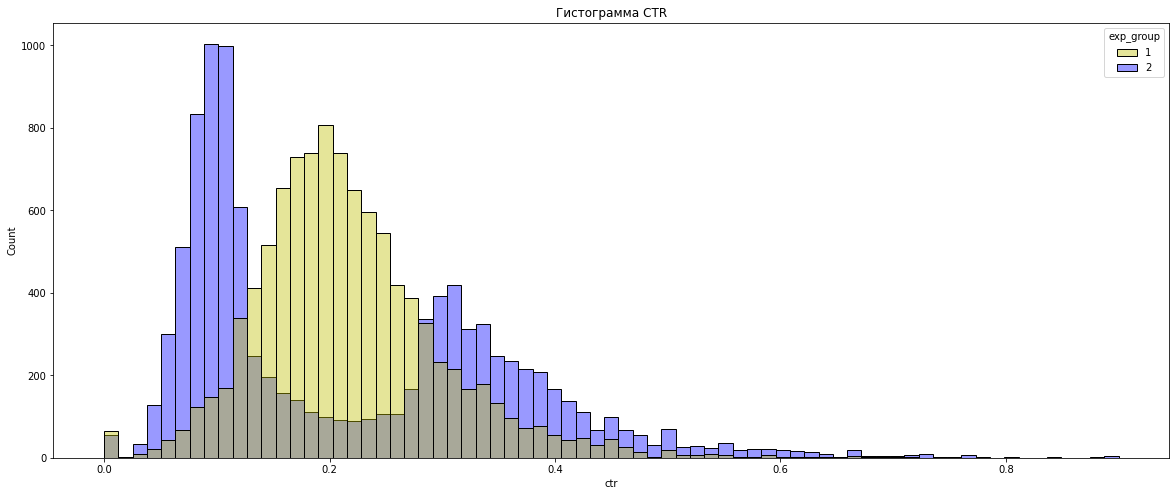

In [17]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма CTR')
sns.histplot(data=abgroup.df[['ctr', 'exp_group']],x='ctr', hue='exp_group', palette = ['y', 'b'], alpha = 0.4);

Посчитатем средние значения CTR по группам

In [18]:
abgroup.df.groupby('exp_group')['ctr'].mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

In [19]:
print('Размер группы B до CTR <= 0.2 =', abgroup.df.query('exp_group == 2 and ctr <=0.2')['ctr'].count())
print('Размер группы B с CTR > 0.2 =', abgroup.df.query('exp_group == 2 and ctr > 0.2')['ctr'].count())

Размер группы B до CTR <= 0.2 = 5418
Размер группы B с CTR > 0.2 = 4459


Посмотрим на количество просмотров у тех пользователей у кого CTR < 0.2 и посчитаем среднее количество просмотров у тех у кого CTR менее 0.2 и выше 0.2

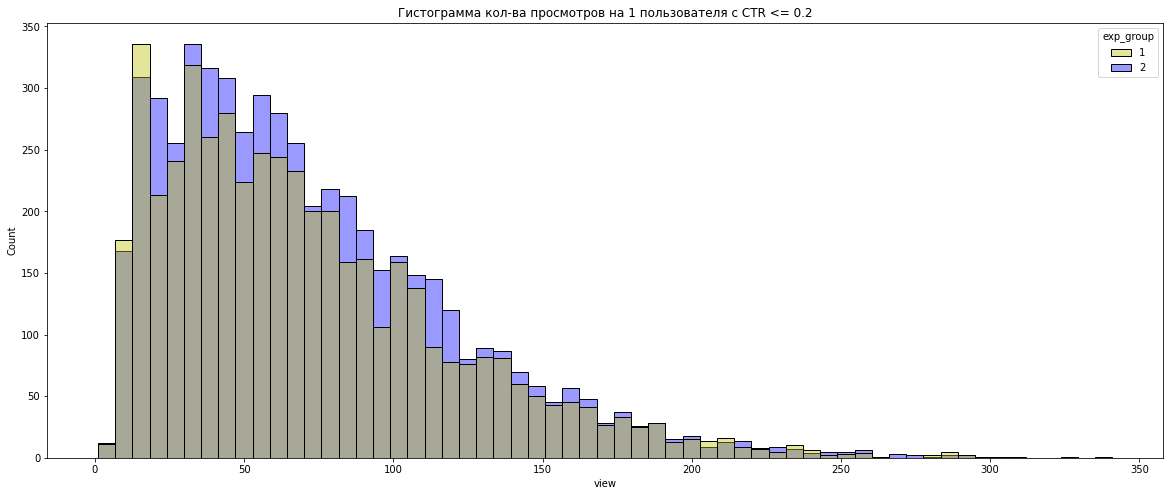

In [20]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма кол-ва просмотров на 1 пользователя с CTR <= 0.2')
sns.histplot(data=abgroup.df.query('ctr <=0.2')[['view', 'exp_group']],x='view', hue='exp_group', palette = ['y', 'b'], alpha = 0.4);

In [21]:
print('Среднее количество просмотров группы B, где CTR <= 0.2 =', abgroup.df.query('exp_group == 2 and ctr <=0.2')['view'].mean().round())
print('Среднее количество просмотров группы B, где CTR > 0.2 =', abgroup.df.query('exp_group == 2 and ctr > 0.2')['view'].mean().round())
print('Среднее количество просмотров группы B =', abgroup.df.query('exp_group == 2')['view'].mean().round())
print('Среднее количество просмотров группы A =', abgroup.df.query('exp_group == 1')['view'].mean().round())

Среднее количество просмотров группы B, где CTR <= 0.2 = 72.0
Среднее количество просмотров группы B, где CTR > 0.2 = 60.0
Среднее количество просмотров группы B = 67.0
Среднее количество просмотров группы A = 67.0


Посмотрим как выглядит сглаженный CTR относительно обычного по группам 

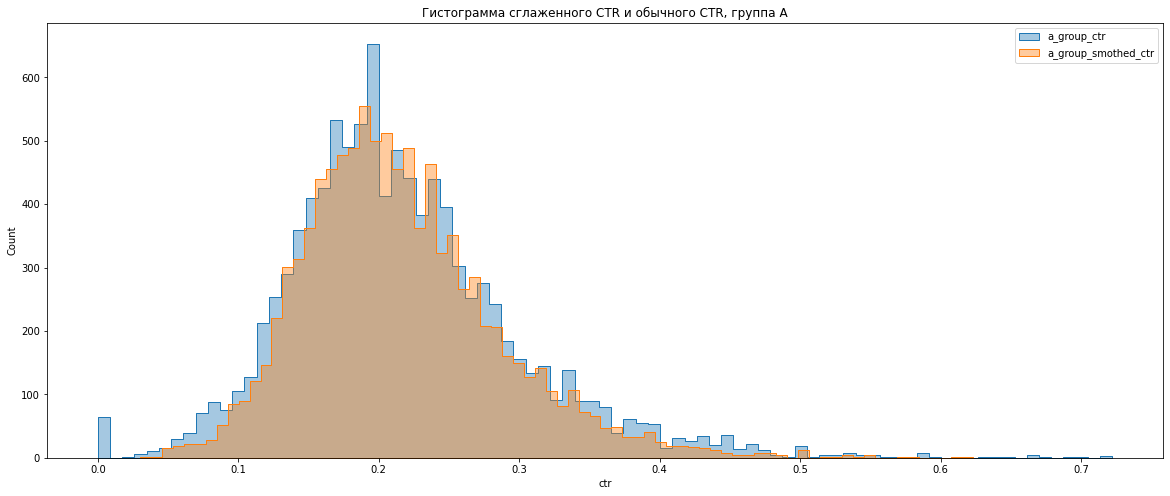

In [22]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма сглаженного CTR и обычного CTR, группа A')
sns.histplot(data=abgroup.df[['ctr', 'exp_group']].query('exp_group == 1'), x='ctr', alpha = 0.4, element="step")
sns.histplot(data=abgroup.df[['smothed_ctr', 'exp_group']].query('exp_group == 1'), x='smothed_ctr', alpha = 0.4, element="step")
plt.legend(["a_group_ctr", "a_group_smothed_ctr"]);
plt.show()

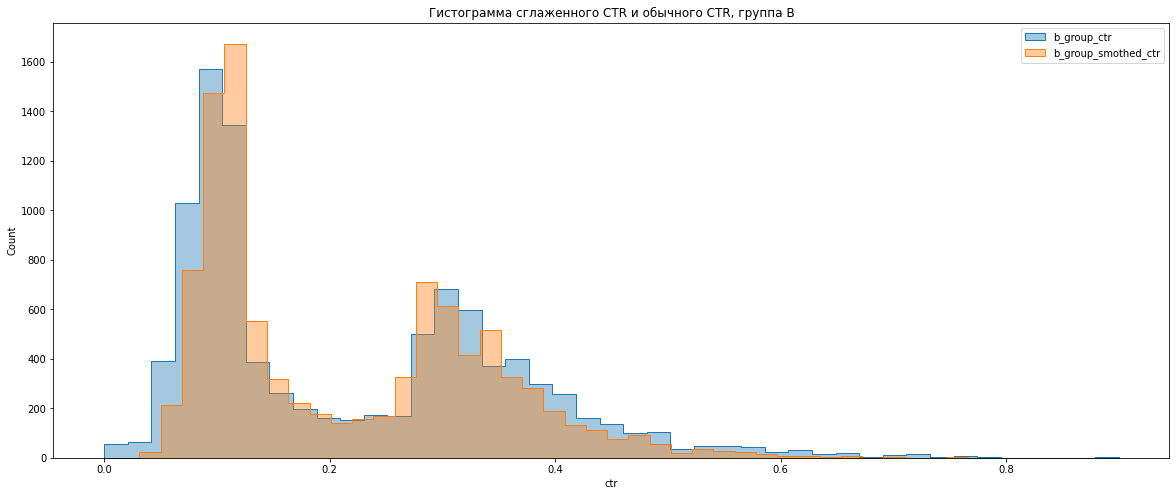

In [23]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма сглаженного CTR и обычного CTR, группа B')
sns.histplot(data=abgroup.df[['ctr', 'exp_group']].query('exp_group == 2'), x='ctr', alpha = 0.4, element="step")
sns.histplot(data=abgroup.df[['smothed_ctr', 'exp_group']].query('exp_group == 2'), x='smothed_ctr', alpha = 0.4, element="step")
plt.legend(["b_group_ctr", "b_group_smothed_ctr"]);
plt.show()

Посчитатем средние значения по сглаженному CTR

In [24]:
abgroup.df.groupby('exp_group')['smothed_ctr'].mean()

exp_group
1    0.215280
2    0.212508
Name: smothed_ctr, dtype: float64

Установим уровень значимости и сформируем переменные с группами A и B

In [25]:
a=0.05
a_group = abgroup.df.query('exp_group == 1')
b_group = abgroup.df.query('exp_group == 2')

## Проведем сравнение с помощью критерия T-теста

Проверим равенство средних t-тестом между всей группой 1 и группой 2
1. H0 - средние между группами равны
2. H1 - средние между группами не равны

a=0.05

In [26]:
ttest_start(a_group, b_group, 'ctr', a)

p_value = 0.685373331140751, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной


Из за специфичного распределения группы B (имеет второй горб в диапазоне 0.2-0.4 и так сказать скошенность вправо) средняя уравнивается со средним контрольной группы, что в свою очередь дает эффект, когда тест показывает большое значение p_value, которое указывает на равенство средних между группами. 

Хотя по факту, в контексте нашей задачи будем делать поправку на формы распределений, а именно, что пользователи разделились как бы на две подгруппы внутри группы B, первая у кого CTR упал, и на тех у кого CTR вырос относительно контрольной группы.

Проведем тест на сглаженном CTR

In [27]:
ttest_start(a_group, b_group, 'smothed_ctr', a)

p_value = 0.05166679015318526, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной


При проведение теста над сглаженным CTR значение p_value хоть и было значительно ниже чем у теста с обычым CTR (0.051 против 0.685), но все равно было больше установленного уровня стат. значимости, в связи с чем мы не можем отвергнуть нулевую гипотезу

## Проведем сравнение с помощью критерия Манна-Уитни

Проведем сравнение с помощью критерия Манна-Уитни
1. H0 - P(Ai>Bi) = P(Bi>Ai)
2. H1 - P(Ai>Bi) <> P(Bi>Ai)

a=0.05

In [28]:
mwh_start(a_group, b_group, 'ctr', a)

p_value = 4.632205841806026e-45, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


У данного типа тестов есть требования к схожести распределения выборок, в нашем случае распределения у выборок значительно отличаются друг от друга, что может давать некорректные результаты теста.

## Пуассоновский бутстреп

Для проведения данного бутсрепа выполним несколько действий:
1. Каждой записи назначаем вес (по большому счету ключевой вес это 0, который зануляет использование данной записи в текущей симуляции, остальные веса, какой-бы величины они не были значат лишь, что число берется для расчета (на итоговый результат размер веса не влияет))
2. С учетом веса посчитаем значения CTR для получающейся группы А и группы B
3. Так повторим 2000 раз, тем самым получим 2000 CTR с группы А и 2000 CTR с группы B
4. Проанализируем получившиеся результаты

In [29]:
bs_a_ctr, bs_b_ctr = poisson_bootstrap(a_group, b_group)

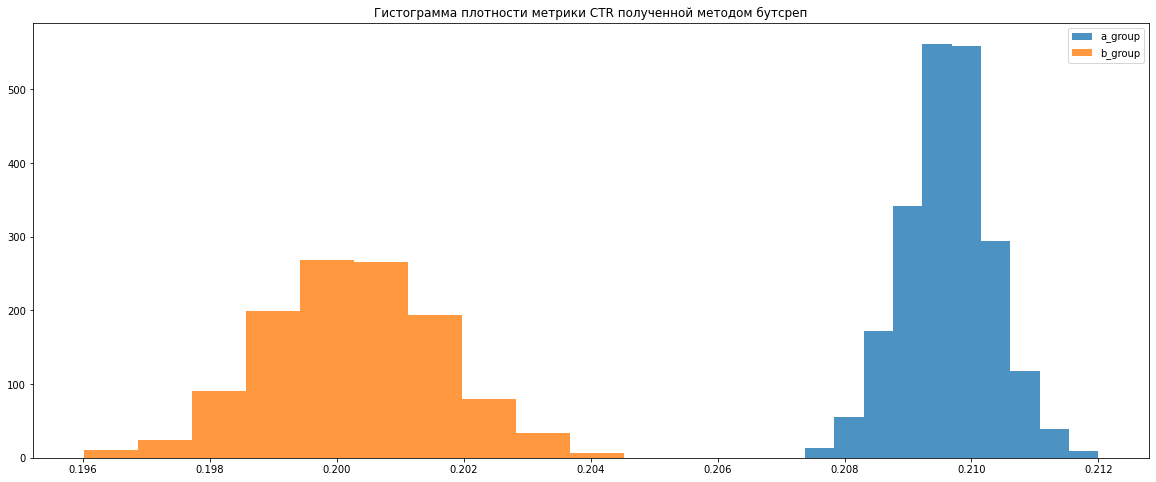

In [30]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма плотности метрики CTR полученной методом бутсреп')
plt.hist(bs_a_ctr, density=True, alpha=0.8)
plt.hist(bs_b_ctr, density=True, alpha=0.8)
plt.legend(["a_group", "b_group"]);

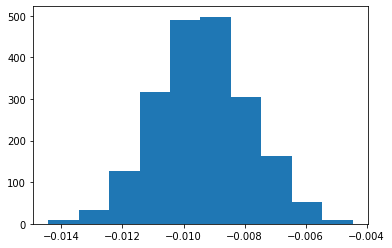

In [31]:
plt.hist(bs_b_ctr - bs_a_ctr);

Ввиду того, что распределения не пересекаются (распределение разницы нам это показывает наглядно), мы можем утрвеждать что ctr прошедший через бутстреп показывает, что контрольная группа А показывает лучшие результаты метрики CTR, чем тестовая

## Бакетное преобразование

Для проведения тестов поверх бакетного преобразования проделаем следующую процедуру

1. С помощью хэширования ид пользователя + соли разобьем наших пользователей на 50 групп (корзин)
2. Считаем по каждой корзине сумму лайков, просмотров и значение CTR
3. Смотрим на распределение и проводим проверку на равенство средних через стат.тесты

In [32]:
abgroup.df['backet'] = (abgroup.df['user_id'].astype(str) + '-backet_test') \
    .swifter.apply(lambda x: int(hl.md5(x.encode('ascii')).hexdigest(), 16) % 50)

Pandas Apply:   0%|          | 0/19897 [00:00<?, ?it/s]

In [33]:
abgroup.df.sample(10, random_state=1000)

,user_id,like,view,exp_group,ctr,smothed_ctr,backet
2243,118436,9,19,2,0.473684,0.416719,23
15088,125328,7,61,2,0.114754,0.121231,45
19547,114330,20,82,1,0.243902,0.241931,44
9776,114056,1,11,1,0.090909,0.128001,30
17348,310,40,165,1,0.242424,0.241459,12
3371,1806,15,66,1,0.227273,0.226028,13
14170,116184,5,12,2,0.416667,0.353015,36
3679,107374,7,68,2,0.102941,0.109606,30
1917,116775,2,13,1,0.153846,0.169334,10
8894,23822,12,66,1,0.181818,0.183775,21


In [34]:
backet_df = abgroup.df.groupby(['exp_group', 'backet']) \
    .agg({'like': sum, 'view': sum, 'ctr': lambda x: np.quantile(x, 0.9)}).reset_index().rename(columns={'ctr': 'ctr_q90'})
backet_df['bckt_ctr'] = backet_df['like'] / backet_df['view']

In [35]:
backet_df.sample(10, random_state=1000)

,exp_group,backet,like,view,ctr_q90,bckt_ctr
88,2,38,2696,14106,0.380481,0.191124
4,1,4,2385,11381,0.326679,0.209560
62,2,12,2631,12382,0.434442,0.212486
63,2,13,2757,14129,0.386538,0.195131
48,1,48,2741,13214,0.314787,0.207432
85,2,35,2701,13470,0.408933,0.200520
73,2,23,2780,14047,0.407015,0.197907
84,2,34,2755,13991,0.374254,0.196912
39,1,39,2963,13846,0.321179,0.213997
47,1,47,3038,15149,0.311944,0.200541


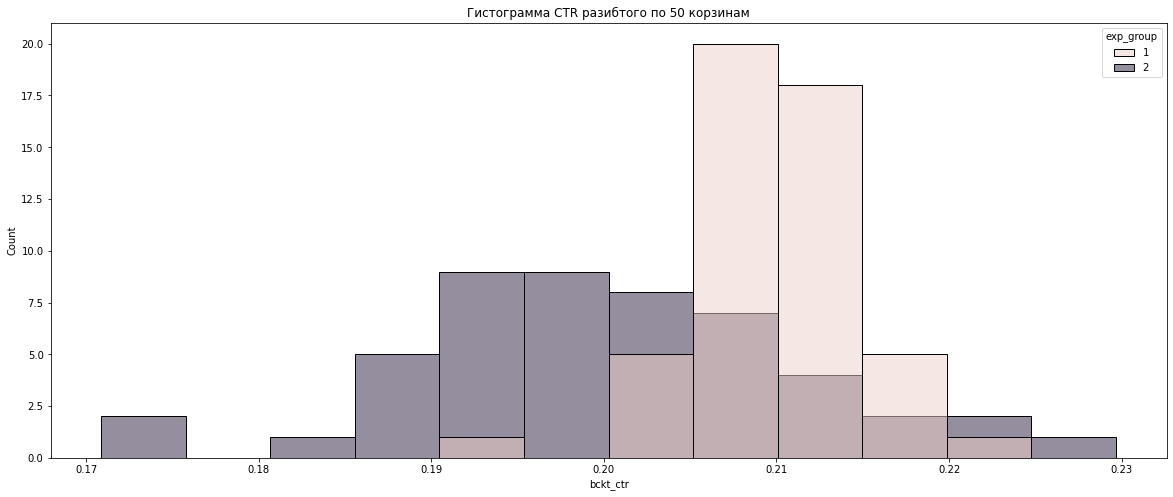

In [36]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма CTR разибтого по 50 корзинам')
sns.histplot(data = backet_df, x='bckt_ctr', hue='exp_group')
plt.show()

In [37]:
backet_df.groupby('exp_group')['bckt_ctr'].apply(lambda x: np.std(x))

exp_group
1    0.004988
2    0.011179
Name: bckt_ctr, dtype: float64

Как видим распределения теперь больше похоже на нормальные, у тестовой группы (2), так же как мы выяснили ранее, результаты CTR растянуты очень широко, а купол находится левее большей части распределения контрольной группы. Стандартное отклонение у тестовой группы больше чем у контрольной. Контрольная же группа сгруппированна у достаточно высокого CTR по сравнению с тестовой группы. 

Посчитаем среднее значение по CTR среди всех корзин

In [38]:
backet_df.groupby('exp_group')['bckt_ctr'].mean()

exp_group
1    0.209689
2    0.200451
Name: bckt_ctr, dtype: float64

### Проверим равенство средних t-тестом между всей группой 1 и группой 2
1. H0 - средние между группами равны
2. H1 - средние между группами не равны

In [39]:
ttest_start(backet_df.query('exp_group == 1'), backet_df.query('exp_group == 2'), 'bckt_ctr', a)

p_value = 1.4585030295061888e-06, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


При проведение т-теста, было получено p_value сильно ниже установленного уровня стат.значимости (0.05), в данном случае мы отвергаем нулевую гипотезу о равенстве средних

### Проведем сравнение с помощью критерия Манна-Уитни
1. H0 - P(Ai>Bi) = P(Bi>Ai)
2. H1 - P(Ai>Bi) <> P(Bi>Ai)

In [40]:
mwh_start(backet_df.query('exp_group == 1'), backet_df.query('exp_group == 2'), 'bckt_ctr', a)

p_value = 4.586985687766298e-07, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


При проведение теста Манна-Уитни, было получено p_value сильно ниже установленного уровня стат.значимости (0.05), в данном случае мы отвергаем нулевую гипотезу о том, что событие когда случайно взятого значение из группы A больше чем случайно взятое значение из группы B равновероятно событию когда случайно взятое значение из группы B больше чем случайно взятое значение из группы A

Результаты теста подтверждают увиденную на графики ситуацию.

## ВЫВОД

В общем надо разобраться с пользователями у которых CTR просел, просмотры у них есть, нету лайков, хз че там у них. Ну и прочее написать здесь

Были полученны данные A/B тестирования за период 2023.08.29 - 2023.09.04, цель тестирования проверка нового рекомендательного алгоритма, который должен привести к увеличению CTR

У нас имеется 19 897 записей (пользователей), которые делятся на две группы.
- Группа 1 (контрольная A) - включает в себя 10020 записей
- Группа 2 (тестовая B) - включает в себя 9877 записи

Средние CTR по группам
exp_group
1. 0.216774
2. 0.216102

Далее проводился ряд статистических тестов, уровень стат.значимости равен 0.05

**Результат t-теста на обычном CTR был следующим**
- p_value = 0.685373331140751

**Этим же тестом был проверен сглаженный CTR:**
- p_value = 0.05166679015318526 сглаженный

Оба раза тест не зафиксировал статистически значимых отклонений, не смотря на то, что тест на сглаженном CTR при уровне стат.значимости 0.1 зафиксировал бы разницу. Результаты теста можно объяснить скошенностью распределения тестовой группы, т.е. из за специфичного распределения группы B (имеет второй горб в диапазоне 0.2-0.4 и так сказать скошенность вправо) средняя уравнивается со средним контрольной группы.

**Так же был, над обычным CTR был проведен тест основанный на критерии Манна-Уитни:**
- p_value = 4.632205841806026e-45

Результат данного теста стоит воспринимать с осторожностью, т.к. одно из требований теста Манна-Уитни это схожесть распределений, чего в нашем случае нет.

**Пуассоновский бутстреп**

Было выполненно 2000 симуляций на каждую группу, т.е. было получено 4000 CTR (по 2000 на каждую группу). Ввиду того, что на графике мы видим, что распределения не пересекаются (распределение разницы нам это показывает наглядно), мы можем утрвеждать что ctr прошедший через бутстреп показывает, что контрольная группа А показывает лучшие результаты метрики CTR, чем тестовая

**Бакетное преобразование**
Среднии значения CTR группы A(1) и B(2) после бакетного преобразования

1. 0.209689
2. 0.200451

Над полученными корзинами было проведено два теста:

- С помощью t-теста было получено p_value = 1.4585030295061888e-06
- С помощью теста Манна-Уитни было получено p_value = 4.586985687766298e-07

Оба теста зафиксировали статистически значимую разницу между группами, как следствие можно отклонить нулевую гипотезу о равенстве средних

На основании вышесказанного можно сделать следующий вывод:
Новый рекомендательный алгоритм разделил тестовую группу на 2 части, на тех у кого CTR сдвинулся вправо и на тех у кого CTR сдвинулся влево относительно большей части распределения контрольной группы. При этом по гистограмме количества просмотров на 1 пользователя нельзя сказать, что есть какое-то падение просмотра у тех пользователей группы B, CTR которых находится слева от основной части распределения. 

Статистические тесты же, особенно бутсреп, т-тест и тест Манна - Уитни поверх бакетного преобразования обнаружили статистически значимую разницу между средними двух групп в пользу контрольной группы.

На текущий момент я бы не рекомендовал раскатывать данный алгоритм на всех пользователей. Возможно стоит попробовать выяснить причину, почему произошло разделение группы B на так сказать две части пользователей, чтобы выявить причину падения CTR и по возможности внести изменения, оставив при этом те причины, которые у другой части привели к увеличению CTR
